In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

In [2]:
data = pd.ExcelFile("data/Data Analysis 1.xlsx")
data = data.parse("Sheet1")

In [3]:
data.columns

Index(['ClientFileNumber', 'mode', 'gender', 'state', 'city', 'dob',
       'createdAt', 'createdDate', 'creditorBalanceTotal', 'tenor',
       'spaFirstDraftDate', 'salary', 'businessIncome', 'familySupport',
       'otherIncome', 'housingLoan', 'autoLoan', 'loansAgainstSecurity',
       'loansAgainstSecurity.1', 'digitalSubscriptionsExpense', 'phoneBill',
       'diningOutExpense', 'miscellaneousExpenses', 'totalIncome',
       'total_secured_debt_obligation', 'totalMonthlyExpense',
       'availableIncome', 'proposedDSPayment', 'stdiPercentage',
       'hardshipReason', 'employmentStatus', 'creditScore', 'AutopayBankName',
       'spaDay', 'msfDay', 'clientFileStatus', 'wad', 'msfAmount',
       'totalMonthlyObligation', 'accountNumber', 'ifscCode', 'PLCount',
       'CCCount', 'PLBalance', 'CCBalance', 'AverageDebt', 'SPABalance',
       'signedOn', ' travelFuel', ' househelp', ' outing', ' medical',
       ' essentialcare', ' schoolfee', ' schoolbus', ' booksandproject',
       ' 

In [4]:
data.head()

,ClientFileNumber,mode,gender,state,city,dob,createdAt,createdDate,creditorBalanceTotal,tenor,...,sip,stocktrades,other,collatoralizedBusinessLoan,rentMaintenance,groceryExpense,electricityBill,gasBill,otherUtilities,reasonforhardship
0,Test001AA0720,MAN,MALE,NaN,NaN,1980-10-03 00:00:00,2020-07-28T16:19:53.105+05:30,2020-07-28,100000.0,6.0,...,0,0,0,0.0,0,0,0,0,0,NaN
1,Test001AA0720,MAN,MALE,NaN,NaN,1980-10-03 00:00:00,2020-07-28T16:19:53.105+05:30,2020-07-28,100000.0,6.0,...,0,0,0,0.0,0,0,0,0,0,NaN
2,FB0002,MAN,MALE,NaN,NaN,2020-07-01 00:00:00,2020-07-29T22:54:26.338+05:30,2020-07-29,100000.0,24.0,...,0,0,0,0.0,0,2500,2500,0,0,NaN
3,AFF002,MAN,MALE,NaN,NaN,2020-07-01 00:00:00,2020-07-29T23:01:47.263+05:30,2020-07-29,100000.0,9.0,...,0,0,0,0.0,0,2500,2500,0,0,NaN
4,Test002AA0720,MAN,MALE,NaN,NaN,1980-11-03 00:00:00,2020-07-30T11:35:07.309+05:30,2020-07-30,100000.0,18.0,...,0,0,0,0.0,0,0,0,0,0,NaN


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19166 entries, 0 to 19165
Data columns (total 70 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   ClientFileNumber               19166 non-null  object        
 1   mode                           19166 non-null  object        
 2   gender                         16986 non-null  object        
 3   state                          18623 non-null  object        
 4   city                           18379 non-null  object        
 5   dob                            17093 non-null  object        
 6   createdAt                      19166 non-null  object        
 7   createdDate                    19166 non-null  datetime64[ns]
 8   creditorBalanceTotal           19166 non-null  float64       
 9   tenor                          9189 non-null   float64       
 10  spaFirstDraftDate              9189 non-null   datetime64[ns]
 11  salary         

In [6]:
# Strip any leading or trailing whitespace from the column names
data.columns = data.columns.str.strip()

In [7]:
data["employmentStatus"].value_counts()

employmentStatus
Salaried         4071
Business          909
Unemployed        151
Self Employed       1
Name: count, dtype: int64

In [8]:
data['availableIncome'].mean()

-82362.60004128766

## Data Preprocessing

In [9]:
# Convert dob to datetime format
data['dob'] = pd.to_datetime(data['dob'], format='%m/%d/%Y', errors='coerce')

# Calculate age by subtracting dob from createdDate
data['age'] = data['createdDate'].dt.year - data['dob'].dt.year

In [10]:
data = data[data["clientFileStatus"]!="LEAD"]

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6049 entries, 23 to 19164
Data columns (total 71 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   ClientFileNumber               6049 non-null   object        
 1   mode                           6049 non-null   object        
 2   gender                         6043 non-null   object        
 3   state                          6045 non-null   object        
 4   city                           6040 non-null   object        
 5   dob                            6040 non-null   datetime64[ns]
 6   createdAt                      6049 non-null   object        
 7   createdDate                    6049 non-null   datetime64[ns]
 8   creditorBalanceTotal           6049 non-null   float64       
 9   tenor                          6047 non-null   float64       
 10  spaFirstDraftDate              6047 non-null   datetime64[ns]
 11  salary              

#### Remove Unimportant and null columns

In [12]:
## Drop customer identifier, text extensive and not important feature columns
df = data.drop(["ClientFileNumber", "state", "city", "dob", "AutopayBankName","accountNumber", "ifscCode","hardshipReason","createdAt"], axis=1) 

In [13]:
# Define threshold for dropping columns (Used 75%)
threshold = 0.75 * len(df)
# Drop columns with missing values exceeding the threshold
df.dropna(axis=1, thresh=threshold, inplace=True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6049 entries, 23 to 19164
Data columns (total 59 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   mode                           6049 non-null   object        
 1   gender                         6043 non-null   object        
 2   createdDate                    6049 non-null   datetime64[ns]
 3   creditorBalanceTotal           6049 non-null   float64       
 4   tenor                          6047 non-null   float64       
 5   spaFirstDraftDate              6047 non-null   datetime64[ns]
 6   salary                         6049 non-null   float64       
 7   businessIncome                 6049 non-null   float64       
 8   familySupport                  6049 non-null   float64       
 9   otherIncome                    6049 non-null   float64       
 10  housingLoan                    6049 non-null   float64       
 11  autoLoan            

#### Remove duplicated columns

In [15]:
# Transpose the DataFrame and check for duplicated rows
duplicate_columns = df.T.duplicated()
duplicate_columns_indices = duplicate_columns[duplicate_columns].index.tolist()

# Drop the duplicated columns
df.drop(duplicate_columns_indices, axis=1, inplace=True)
print("Duplicate Columns:", duplicate_columns_indices)

Duplicate Columns: ['loansAgainstSecurity.1', 'totalMonthlyExpense']


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6049 entries, 23 to 19164
Data columns (total 57 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   mode                           6049 non-null   object        
 1   gender                         6043 non-null   object        
 2   createdDate                    6049 non-null   datetime64[ns]
 3   creditorBalanceTotal           6049 non-null   float64       
 4   tenor                          6047 non-null   float64       
 5   spaFirstDraftDate              6047 non-null   datetime64[ns]
 6   salary                         6049 non-null   float64       
 7   businessIncome                 6049 non-null   float64       
 8   familySupport                  6049 non-null   float64       
 9   otherIncome                    6049 non-null   float64       
 10  housingLoan                    6049 non-null   float64       
 11  autoLoan            

In [17]:
df["gender"].value_counts()

gender
MALE      5769
FEMALE     274
Name: count, dtype: int64

In [18]:
df["clientFileStatus"].value_counts()

clientFileStatus
CANCELLED                   4185
ACTIVE                       604
GRADUATED                    416
HOLD                         301
PARTIALLY_GRADUATED          268
PENDING_CANCELLED            169
AGREEMENT_SIGNED_REVOKED      74
AGREEMENT_SIGNED              29
REJECTED                       3
Name: count, dtype: int64

Highly imbalanced target column!

In [19]:
income_cols = ['salary', 'businessIncome', 'familySupport', 'otherIncome', 'totalIncome', 'availableIncome']
expense_cols = ['digitalSubscriptionsExpense', 'phoneBill', 'diningOutExpense', 
                'miscellaneousExpenses', 'travelFuel', 'househelp', 'outing', 
                'medical', 'essentialcare', 'schoolfee', 'schoolbus', 'booksandproject', 
                'nursingattendent', 'petcare', 'healthinsurance', 'vehicleinsurance', 
                'sip', 'stocktrades', 'other', 'rentMaintenance', 'groceryExpense', 
                'electricityBill', 'gasBill', 'otherUtilities']
loan_cols = ["housingLoan", 'autoLoan', 'loansAgainstSecurity']


In [20]:
def clean_and_convert(column):
    # Remove non-numeric characters except the decimal point
    def extract_numerics(s):
        match = re.search(r'-?\d+\.?\d*', s)
        return match.group() if match else np.nan

    # Apply extraction and conversion
    column = column.apply(lambda x: extract_numerics(str(x)))
    
    return column.astype(float)

# Apply the cleaning function
for col in df[income_cols].select_dtypes(include=['object']).columns:
    try:
        df[col] = clean_and_convert(df[col])
        print(f"Converted {col} to float.")
    except ValueError as e:
        print(f"Column {col} cannot be converted to float. Error: {e}")

for col in df[expense_cols].select_dtypes(include=['object']).columns:
    try:
        df[col] = clean_and_convert(df[col])
        print(f"Converted {col} to float.")
    except ValueError as e:
        print(f"Column {col} cannot be converted to float. Error: {e}")

for col in df[loan_cols].select_dtypes(include=['object']).columns:
    try:
        df[col] = clean_and_convert(df[col])
        print(f"Converted {col} to float.")
    except ValueError as e:
        print(f"Column {col} cannot be converted to float. Error: {e}")

Converted househelp to float.
Converted outing to float.
Converted medical to float.
Converted essentialcare to float.
Converted schoolfee to float.
Converted schoolbus to float.
Converted booksandproject to float.
Converted nursingattendent to float.
Converted petcare to float.
Converted healthinsurance to float.
Converted vehicleinsurance to float.
Converted sip to float.
Converted stocktrades to float.
Converted other to float.
Converted rentMaintenance to float.
Converted groceryExpense to float.
Converted electricityBill to float.
Converted gasBill to float.
Converted otherUtilities to float.


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6049 entries, 23 to 19164
Data columns (total 57 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   mode                           6049 non-null   object        
 1   gender                         6043 non-null   object        
 2   createdDate                    6049 non-null   datetime64[ns]
 3   creditorBalanceTotal           6049 non-null   float64       
 4   tenor                          6047 non-null   float64       
 5   spaFirstDraftDate              6047 non-null   datetime64[ns]
 6   salary                         6049 non-null   float64       
 7   businessIncome                 6049 non-null   float64       
 8   familySupport                  6049 non-null   float64       
 9   otherIncome                    6049 non-null   float64       
 10  housingLoan                    6049 non-null   float64       
 11  autoLoan            

In [22]:
# Impute missing values for categorical columns with mode
categorical_columns = df.select_dtypes(include=['object']).columns
print("Column : Mode")
for column in categorical_columns:
    ## If no null entries skip
    if df[column].isnull().sum() == 0:
        continue

    df.fillna({column:df[column].mode()[0]}, inplace=True)
    print(f"{column}: {df[column].mode()[0]}")

print("*"*50)

# Impute missing values for numerical columns with median
numerical_columns = df.select_dtypes(include=['number']).columns
print("Column : Median")
for column in numerical_columns:
    ## If no null entries skip
    if df[column].isnull().sum() == 0:
        continue
    df.fillna({column:df[column].mean()}, inplace=True)
    print(f"{column}: {df[column].median()}")
print("*"*50)

# Verify if there are any remaining missing values
remaining_missing_values = df.isnull().sum()
print("Remaing Missing Values:")
print(remaining_missing_values)
print("*"*50)

Column : Mode
gender: MALE
**************************************************
Column : Median
tenor: 24.0
creditScore: 686.0
spaDay: 10.0
msfDay: 1.0
wad: 122.0
msfAmount: 0.0
totalMonthlyObligation: 8840.0
age: 32.0
**************************************************
Remaing Missing Values:
mode                             0
gender                           0
createdDate                      0
creditorBalanceTotal             0
tenor                            0
spaFirstDraftDate                2
salary                           0
businessIncome                   0
familySupport                    0
otherIncome                      0
housingLoan                      0
autoLoan                         0
loansAgainstSecurity             0
digitalSubscriptionsExpense      0
phoneBill                        0
diningOutExpense                 0
miscellaneousExpenses            0
totalIncome                      0
total_secured_debt_obligation    0
availableIncome                  0
proposed

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6049 entries, 23 to 19164
Data columns (total 57 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   mode                           6049 non-null   object        
 1   gender                         6049 non-null   object        
 2   createdDate                    6049 non-null   datetime64[ns]
 3   creditorBalanceTotal           6049 non-null   float64       
 4   tenor                          6049 non-null   float64       
 5   spaFirstDraftDate              6047 non-null   datetime64[ns]
 6   salary                         6049 non-null   float64       
 7   businessIncome                 6049 non-null   float64       
 8   familySupport                  6049 non-null   float64       
 9   otherIncome                    6049 non-null   float64       
 10  housingLoan                    6049 non-null   float64       
 11  autoLoan            

Now that we have have preprocessed the data its time to perform some EDA!

In [24]:
df['Churn'] = df['clientFileStatus'].apply(lambda x: 0 if x in ['PARTIALLY_GRADUATED', 'ACTIVE', 'GRADUATED','AGREEMENT_SIGNED'] else 1)

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6049 entries, 23 to 19164
Data columns (total 58 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   mode                           6049 non-null   object        
 1   gender                         6049 non-null   object        
 2   createdDate                    6049 non-null   datetime64[ns]
 3   creditorBalanceTotal           6049 non-null   float64       
 4   tenor                          6049 non-null   float64       
 5   spaFirstDraftDate              6047 non-null   datetime64[ns]
 6   salary                         6049 non-null   float64       
 7   businessIncome                 6049 non-null   float64       
 8   familySupport                  6049 non-null   float64       
 9   otherIncome                    6049 non-null   float64       
 10  housingLoan                    6049 non-null   float64       
 11  autoLoan            

In [26]:
df.to_csv("data/cleaned_data.csv", index=False)

## Segmentation

In [27]:
def remove_highly_correlated_columns(df, threshold=0.75):
    # Select only float and int columns
    df_numeric = df.select_dtypes(include=[np.number])
    
    # Compute the correlation matrix
    corr_matrix = df_numeric.corr().abs()

    # Select the upper triangle of the correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find index of feature columns with correlation greater than the threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    # Drop highly correlated columns from the original dataframe
    print(f"Dropping Columns: {to_drop}")
    return df.drop(columns=to_drop)

In [28]:
df = remove_highly_correlated_columns(df)

Dropping Columns: ['totalIncome', 'total_secured_debt_obligation', 'proposedDSPayment', 'PLBalance']


In [29]:
def onehot_encode_dataframe(df):
    """
    Converts all categorical columns in the DataFrame to One-Hot Encoded representations.

    Parameters:
    df (pd.DataFrame): The input DataFrame.

    Returns:
    pd.DataFrame: The DataFrame with categorical columns One-Hot Encoded.
    """
    # Identify categorical columns
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    
    # One-Hot Encode the categorical columns
    df_encoded = pd.get_dummies(df, columns=categorical_columns)
    
    return df_encoded

In [30]:
X = onehot_encode_dataframe(df.drop(["Churn"], axis=1).select_dtypes(include=[float,int, bool]))
Y = df["Churn"]

In [31]:
print(X.shape, Y.shape)

(6049, 48) (6049,)


In [34]:
X_scaled = StandardScaler().fit_transform(X)

In [35]:
# from sklearn.cluster import KMeans
# # Determine the optimal number of clusters using the elbow method
# sse = []
# for k in range(1, 50):
#     kmeans = KMeans(n_clusters=k, random_state=42)
#     kmeans.fit(X_scaled)
#     sse.append(kmeans.inertia_)

# plt.figure(figsize=(10, 5))
# plt.plot(range(1, 50), sse, marker='o')
# plt.xlabel('Number of clusters')
# plt.ylabel('SSE')
# plt.title('Elbow Method')
# plt.show()

In [36]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt

def determine_optimal_clusters(X_scaled, max_clusters=50, random_state=42):
    search_range = range(1, max_clusters + 1)
    sse = []
    report = {}
    
    for k in search_range:
        temp_dict = {}
        kmeans = KMeans(init='k-means++', n_clusters=k, max_iter=1000, random_state=random_state, verbose=0)
        kmeans.fit(X_scaled)
        inertia = kmeans.inertia_
        sse.append(inertia)
        temp_dict['Sum of squared error'] = inertia
        
        try:
            cluster = kmeans.predict(X_scaled)
            chs = metrics.calinski_harabasz_score(X_scaled, cluster)
            ss = metrics.silhouette_score(X_scaled, cluster)
            temp_dict['Calinski Harabasz Score'] = chs
            temp_dict['Silhouette Score'] = ss
        except:
            pass
        
        report[k] = temp_dict

    report_df = pd.DataFrame(report).T

    # Plotting the other metrics
    report_df.plot(figsize=(15, 10), xticks=search_range, grid=True, title=f'Selecting optimal "K"', subplots=True, marker='o', sharex=True)
    plt.tight_layout()
    plt.show()
    
    return report_df


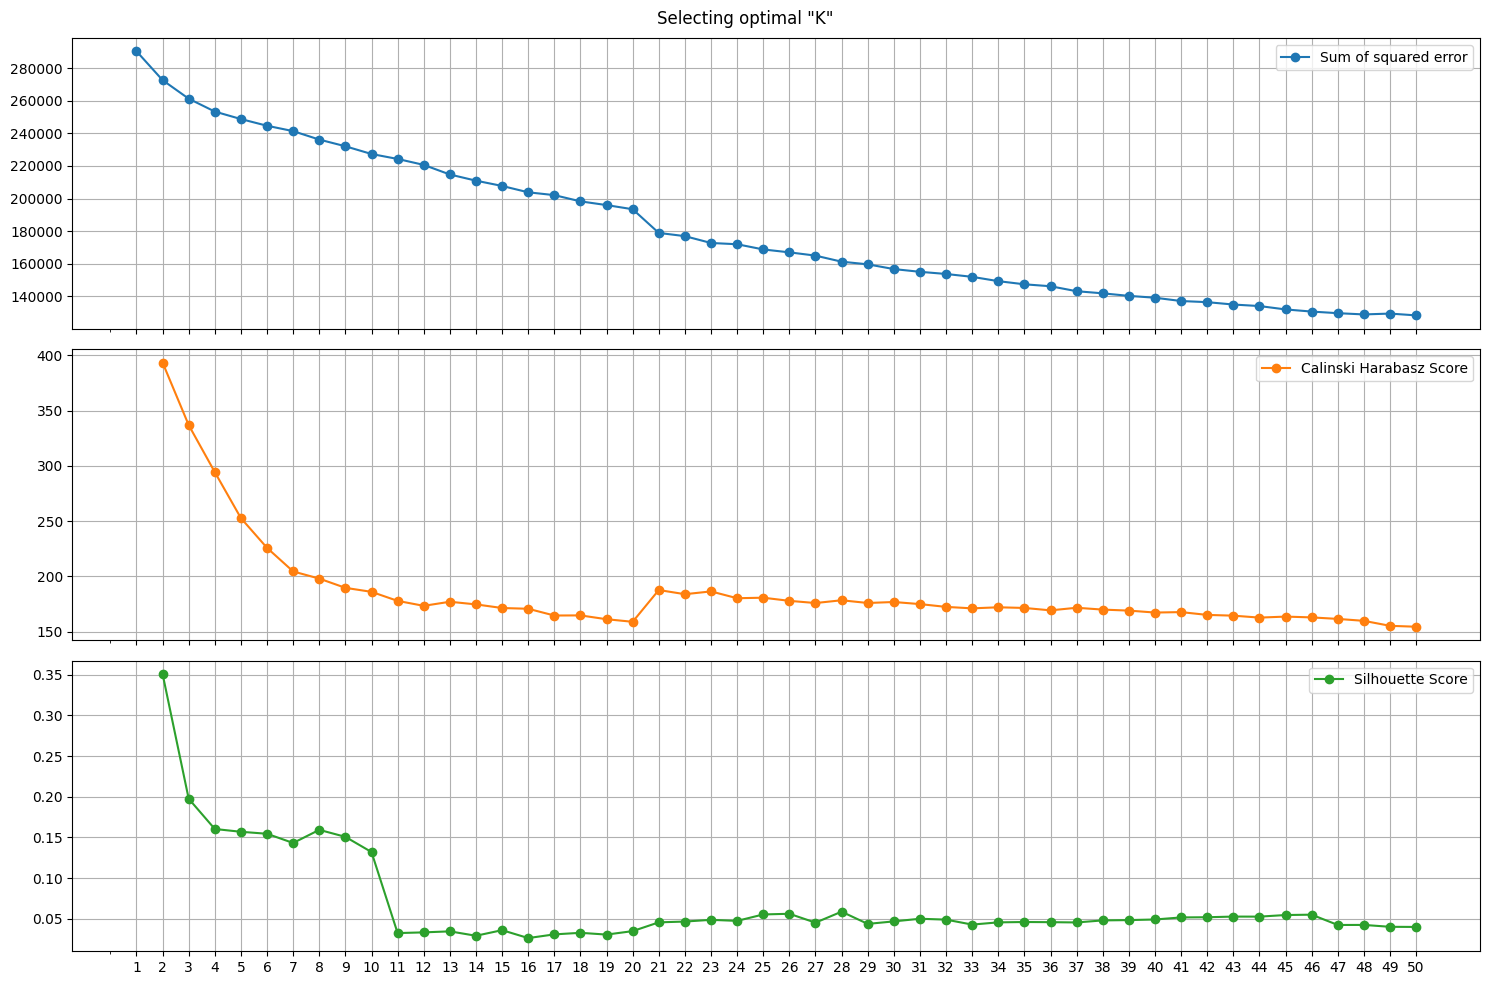

In [37]:
report = determine_optimal_clusters(X_scaled, max_clusters=50)

In [39]:
optimal_clusters = 5  # Example value, select based on the elbow plot
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
X['Cluster'] = kmeans.fit_predict(X_scaled)

In [40]:
X_scaled.shape

(6049, 48)

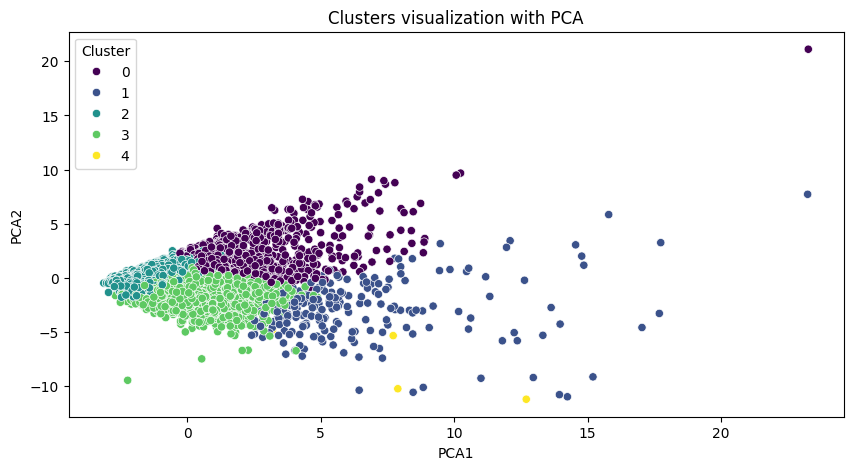

In [47]:
from sklearn.decomposition import PCA

pca = PCA(n_components=X_scaled.shape[1])
pca_data = pca.fit_transform(X_scaled)

X['PCA1'] = pca_data[:, 0]
X['PCA2'] = pca_data[:, 1]

plt.figure(figsize=(10, 5))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=X, palette='viridis')
plt.title('Clusters visualization with PCA')
plt.show()

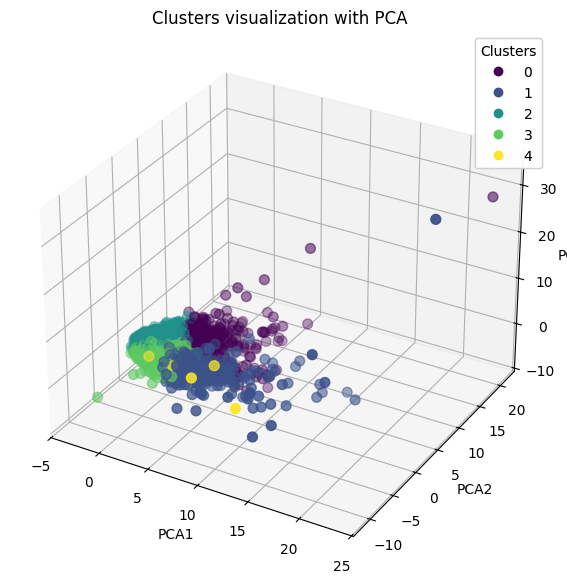

In [41]:
pca = PCA(n_components=3)
pca_data = pca.fit_transform(X_scaled)

# Add PCA components to DataFrame
X['PCA1'] = pca_data[:, 0]
X['PCA2'] = pca_data[:, 1]
X['PCA3'] = pca_data[:, 2]

# Create 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plotting the points
scatter = ax.scatter(X['PCA1'], X['PCA2'], X['PCA3'], c=X['Cluster'], cmap='viridis', s=50)

# Adding labels and title
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
ax.set_title('Clusters visualization with PCA')

# Adding legend
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.show()

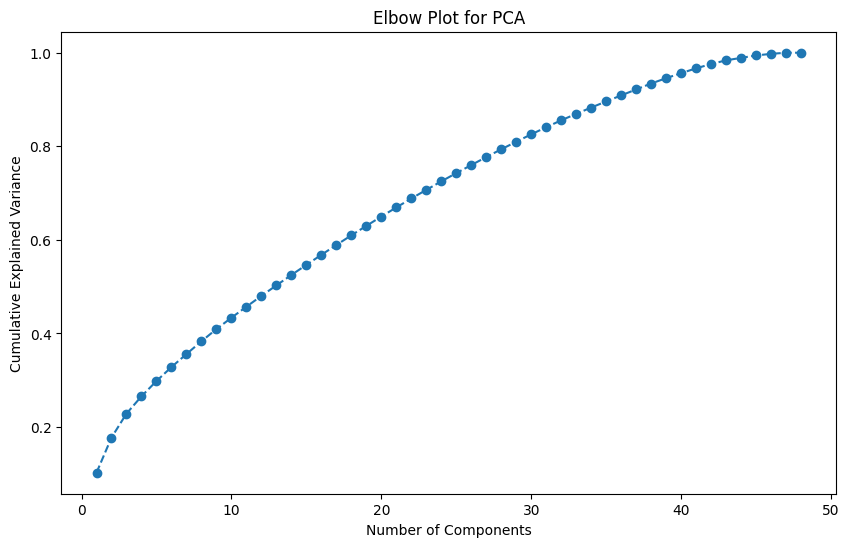

In [48]:
pca = PCA()
pca.fit(X_scaled)

# Plot the explained variance ratio to see the elbow
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Elbow Plot for PCA')
plt.show()

### Analyze Clusters

Choose number of transformed features  = 5

## Churn Prediction

In [81]:

# Define churn (example: not graduated if clientFileStatus is 'Graduate')
df['Churn'] = df['clientFileStatus'].apply(lambda x: 0 if x in ['PARTIALLY_GRADUATED', 'ACTIVE', 'GRADUATED','AGREEMENT_SIGNED'] else 1)

# Feature selection
features = df.select_dtypes(include=[float, int]).drop('Churn', axis=1)
target = df['Churn']

features_scaled = StandardScaler().fit_transform(features)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.33, random_state=42)

# Train the model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
# Print model accuracy
print(f'Test Accuracy: {accuracy_score(y_test, y_pred)}')
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f'ROC-AUC Score: {roc_auc_score(y_test, y_pred)}')

Test Accuracy: 0.8813219829744617
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.68      0.72       452
           1       0.91      0.94      0.92      1545

    accuracy                           0.88      1997
   macro avg       0.84      0.81      0.82      1997
weighted avg       0.88      0.88      0.88      1997

ROC-AUC Score: 0.8098283071283329
